In [66]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

df = pd.read_csv('income.csv')

In [67]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

In [68]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [69]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [74]:
cats = np.stack([df[i].cat.codes.values for i in cat_cols], axis=1)
cats = torch.tensor(cats, dtype=torch.int64)

In [75]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)

In [76]:
def test_train_split(b=30000,t=5000,y=y, cats=cats, conts=conts):
  b = b 
  t = t  

  cat_train = cats[:b-t]
  cat_test  = cats[b-t:b]
  con_train = conts[:b-t]
  con_test  = conts[b-t:b]
  y_train   = y[:b-t]
  y_test    = y[b-t:b]

  return cat_train,cat_test,con_train,con_test,y_train,y_test


In [78]:
cat_train,cat_test,con_train,con_test,y_train,y_test = test_train_split()

In [79]:
class Model(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        
        layerlist = []
        
        
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        
        x = self.emb_drop(x)
        
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        
        x = self.layers(x)
        return x

In [86]:
torch.manual_seed(33)
model = Model(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

Model(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [89]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, torch.tensor(y_train))
    losses.append(loss)
    
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:   1  loss: 0.34916437
epoch:  26  loss: 0.34101418
epoch:  51  loss: 0.33217695
epoch:  76  loss: 0.32419202
epoch: 101  loss: 0.32067481
epoch: 126  loss: 0.31340200
epoch: 151  loss: 0.30914336
epoch: 176  loss: 0.30537280
epoch: 201  loss: 0.30129620
epoch: 226  loss: 0.30014244
epoch: 251  loss: 0.29952344
epoch: 276  loss: 0.29647329


In [92]:
loss_df = []
for i in losses:
  loss_df.append(i.item())

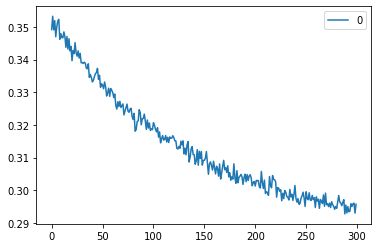

In [93]:
pd.DataFrame(loss_df).plot()

In [95]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, torch.tensor(y_test))
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.30407545


In [127]:
rows = len(y_test)
correct = 0
for i in range(rows):
    #print(f'{y_val[i].argmax().item():^7}{y_test[i]:^7}')
    
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4300 out of 5000 = 86.00% correct


In [120]:

def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)

tensor([-1.3551,  1.3422])
tensor([ 1.1144, -1.6065])
tensor([-0.3683, -0.5074])
tensor([ 2.1416, -2.9280])
tensor([ 7.4596, -7.3229])
tensor([ 0.7746, -0.6897])
tensor([ 4.3617, -4.6792])
tensor([ 1.3327, -0.7359])
tensor([-0.4092, -0.2736])
tensor([ 2.8906, -2.7213])
tensor([ 2.9963, -1.4573])
tensor([-1.2905,  0.1851])
tensor([-0.3945,  0.1037])
tensor([ 0.7786, -2.8400])
tensor([ 6.4576, -7.1358])
tensor([-1.2930, -0.0655])
tensor([ 5.5872, -5.1240])
tensor([-0.5232,  0.4006])
tensor([-0.3509,  1.2094])
tensor([ 0.8840, -1.3882])
tensor([ 3.1363, -2.8283])
tensor([ 1.6765, -1.5230])
tensor([ 3.3854, -4.0100])
tensor([ 6.8727, -4.7966])
tensor([ 2.0223, -1.3909])
tensor([ 0.3410, -0.8109])
tensor([ 0.7972, -0.7386])
tensor([-1.0213,  0.2284])
tensor([-1.1036,  0.3793])
tensor([ 0.5131, -0.6828])
tensor([-0.8488,  0.5739])
tensor([ 2.7332, -2.8049])
tensor([-0.3146,  0.3347])
tensor([ 0.2763, -0.6321])
tensor([ 2.4065, -1.5138])
tensor([ 2.2843, -3.0794])
tensor([ 5.2019, -4.3926])
t

In [ ]:
# DON'T WRITE HERE
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)